## **학습모델가져오기**

In [3]:
!rm -r ./model
!cp -r /content/drive/My\ Drive/share2/강로/model ./

rm: cannot remove './model': No such file or directory


## **빈모델폴더가져오기**

In [ ]:
!rm -r ./model
!cp -r /content/drive/My\ Drive/share2/강로/model_void ./

## **학습모델보내기**

In [ ]:
!cp -r ./model /content/drive/My\ Drive/share2/강로/

## **피쳐가져오기**

In [49]:
!7z x /content/drive/My\ Drive/share/features.7z -pMal_123^^


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/share/                                        1 file, 1564804344 bytes (1493 MiB)

Extracting archive: /content/drive/My Drive/share/features.7z
--
Path = /content/drive/My Drive/share/features.7z
Type = 7z
Physical Size = 1564804344
Headers Size = 1352
Method = LZMA2:24 7zAES
Solid = +
Blocks = 3

  0%      0% 10 - features/0x014c/1718_0.npy                                      1% 10 - features/0x014c/1718_0.npy                                      2% 10 - features/0x014c/1718_0.npy

## **타겟피쳐가져오기**

In [2]:
!7z x /content/drive/My\ Drive/share/target_feature.7z -pMal_123^^


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/share/                                        1 file, 254415504 bytes (243 MiB)

Extracting archive: /content/drive/My Drive/share/target_feature.7z
--
Path = /content/drive/My Drive/share/target_feature.7z
Type = 7z
Physical Size = 254415504
Headers Size = 336
Method = LZMA2:24 7zAES
Solid = +
Blocks = 1

  0%      0% 1        1% 1 - target_feature/0x014c.npy                                    2% 1 - target_feature/0x014c.npy                                    3% 1 - target_feature/0x014c.npy

## **xgboost** **업데이트**

In [6]:
!pip install --upgrade xgboost

     |████████████████████████████████| 148.9MB 99kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


## **모듈불러오기**

In [1]:
from xgboost import XGBRegressor
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from joblib import dump, load
from glob import glob
from copy import deepcopy
from multiprocessing import Process
from sklearn.metrics import accuracy_score
import csv
import matplotlib.pyplot as plt

In [2]:
import xgboost
xgboost.__version__

'1.2.1'

## **피쳐불러오기함수**

In [3]:
def data_loader(path, usage):
  global seed
  aa = list(np.load(path, allow_pickle=True))
  if len(aa) == 0:
    return [], []
  bb = list(map(list, aa))
  cc = np.array(bb)
  xx = list(map(list, list(cc[:,2])))
  yy = list(map(int, cc[:,1]))

  if usage == 'train':
    xx, _, yy, _ = train_test_split(xx, yy, test_size=0.1, random_state=seed) 
  elif usage == 'all':
    xx = np.array(xx).reshape(-1, 256*256)
    yy = np.array(yy)
    names = cc[:,0]
    return xx, yy, names # np, np, np
  else: # valid
    _, xx, _, yy = train_test_split(xx, yy, test_size=0.1, random_state=seed)

  return xx, yy # list, list

## **피쳐불러오기함수_검증용**

In [4]:
# 모든 검증용 데이터 불러옴
def valid_data_loader(path_que):
  X_valid = []
  Y_valid = []
  for path in path_que:
    x, y = data_loader(path, 'valid')
    X_valid += x
    Y_valid += y

  return np.array(X_valid).reshape(-1,256*256), np.array(Y_valid)

## **정상악성갯수맞추기함수**

In [5]:
# 악성 정상 갯수 맞춤
def match_size(X, Y):
  global seed

  X0 = np.array([X[i] for i in range(len(X)) if Y[i] == 0]) # 정상
  X1 = np.array([X[i] for i in range(len(X)) if Y[i] == 1]) # 악성
  Y0 = np.array([Y[i] for i in range(len(X)) if Y[i] == 0]) # 정상
  Y1 = np.array([Y[i] for i in range(len(X)) if Y[i] == 1]) # 악성
  assert len(X0) + len(X1) == len(X)
  # X와 Y 순서 맞추기위해 seed 사용
  np.random.seed(seed)
  np.random.shuffle(X0)
  np.random.seed(seed)
  np.random.shuffle(X1)
  np.random.seed(seed)
  np.random.shuffle(Y0)
  np.random.seed(seed)
  np.random.shuffle(Y1)
  
  print('전부 : ', len(X))
  print('비율 : ',len(X0), len(X1))
  # 정상갯수 적어서 두배늘림
  X0 = np.concatenate([X0, X0])
  Y0 = np.concatenate([Y0, Y0])

  # 갯수맞춤
  X0 = X0[:len(X1)]
  Y0 = Y0[:len(X1)]
  X1 = X1[:len(X0)]
  Y1 = Y1[:len(X0)]
  print('맞춤 : ', len(X0), len(X1))

  # 정상악성 이어붙여서 다시섞기
  X = np.concatenate([X0, X1])
  Y = np.concatenate([Y0, Y1])
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

  return X, Y

## **훈련함수호출함수**

In [6]:
def train(X_batch, Y_batch, zcls, cnt):
  global AX_valid, AY_valid # 모든 검증용 데이터
  print('#################### trainning...(%s, %d)'%(zcls, cnt))
  X = np.array(deepcopy(X_batch)) # 길이 : batch_size
  Y = np.array(deepcopy(Y_batch)) # 길이 : batch_size
  X, Y = match_size(X, Y) # 정상악성갯수맞추기

  X_train = X.reshape(-1, 256*256)
  Y_train = Y

  # 하나 모델 훈련할때마다 검증용 데이터 랜덤500개 사용
  np.random.seed()
  r = np.random.randint(0, 10000)
  np.random.seed(r)
  np.random.shuffle(AX_valid)
  np.random.seed(r)
  np.random.shuffle(AY_valid)
  X_valid = AX_valid[:500]
  Y_valid = AY_valid[:500]

  # RAM 반환되지않는 문제때문에 process를 생성해서 끝날때 강제반환
  fitting_process = Process(target=fitting, args=(X_train, Y_train, X_valid, Y_valid, zcls, cnt))
  fitting_process.start()
  fitting_process.join()

## **훈련후저장함수**

In [7]:
def fitting(X_train, Y_train, X_valid, Y_valid, zcls, cnt):
  param = {'objective':'reg:squaredlogerror'} # 0.970
  # param = {'objective':'binary:logistic'} # 0.961
  # param = {'objective':'reg:logistic'} # 0.961

  xgbr = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, tree_method='gpu_hist', gpu_id=0, **param)
  # xgbr.fit(X_train, Y_train, eval_metric='auc', eval_set=[(X_train, Y_train),(X_valid, Y_valid)])
  xgbr.fit(X_train, Y_train, early_stopping_rounds=20, eval_metric='rmse', eval_set=[(X_train, Y_train),(X_valid, Y_valid)])

  # batch_size만큼 학습한 모델 저장함
  dump(xgbr, './model/%s/model_%d.joblib.dat'%(zcls, cnt))

## **피쳐로드**, **훈련**

In [ ]:
batch_size = 2000
seed = 888

# zclass = ['0x014c', '0x0166', '0x0184', '0x01c4', \
#           '0x8664', '0xaa64', 'NonPE']
zclass = ['0x014c', '0x8664', 'NonPE']
# 0x0166 # 0: 299개 1: 1개
# 0x0184 # 0: 159개 1: 0개
# 0x01c4 # 0: 637개 1: 0개
# 0xaa64 # 0: 191개 1: 0개
# elsePE # label이 다 0 이라서 학습불가
for zcls in zclass:
  X_que = [] # 큐
  Y_que = []
  path_que = glob('./features/%s/2019_*.npy'%zcls)
  AX_valid, AY_valid = valid_data_loader(path_que) # 모든 검증용 데이터 # 모든 데이터의 1할

  cnt = len(glob('./model/%s/model*'%zcls)) # 모델 번호
  while len(path_que) > 0:
    XX, YY = data_loader(path_que.pop(0), 'train')
    X_que += XX # 리필
    Y_que += YY
    while len(X_que) > batch_size: # batch_size만큼 사용한다
      train(X_que[:batch_size], Y_que[:batch_size], zcls, cnt)
      del X_que[:batch_size], Y_que[:batch_size]
      cnt += 1 # 모델 번호
  if len(X_que) > 0: # 큐에 남은 데이터 마저 학습
    train(X_que[:batch_size], Y_que[:batch_size], zcls, cnt)
    del X_que[:batch_size], Y_que[:batch_size]
    

#################### trainning...(0x014c, 16)
전부 :  2000
비율 :  749 1251
맞춤 :  1251 1251
[0]	validation_0-rmse:0.46878	validation_1-rmse:0.47953
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.44434	validation_1-rmse:0.46482
[2]	validation_0-rmse:0.42199	validation_1-rmse:0.45267
[3]	validation_0-rmse:0.40020	validation_1-rmse:0.44206
[4]	validation_0-rmse:0.38197	validation_1-rmse:0.43295
[5]	validation_0-rmse:0.36436	validation_1-rmse:0.42414
[6]	validation_0-rmse:0.34814	validation_1-rmse:0.41574
[7]	validation_0-rmse:0.33488	validation_1-rmse:0.40756
[8]	validation_0-rmse:0.32352	validation_1-rmse:0.40063
[9]	validation_0-rmse:0.31065	validation_1-rmse:0.39476
[10]	validation_0-rmse:0.30149	validation_1-rmse:0.38868
[11]	validation_0-rmse:0.29143	validation_1-rmse:0.38306
[12]	validation_0-rmse:0.28086	validation_1-rmse:0.37776
[13]	validation_0-rmse

## **evals_result**

[0.244066, 0.278141, 0.240702, 0.263577, 0.272726, 0.248113, 0.263215, 0.227773, 0.276535, 0.257205, 0.277459, 0.25606, 0.264251, 0.279838, 0.287163, 0.27596, 0.260787, 0.257885, 0.27818, 0.246832, 0.234902, 0.250635, 0.283328, 0.25232]


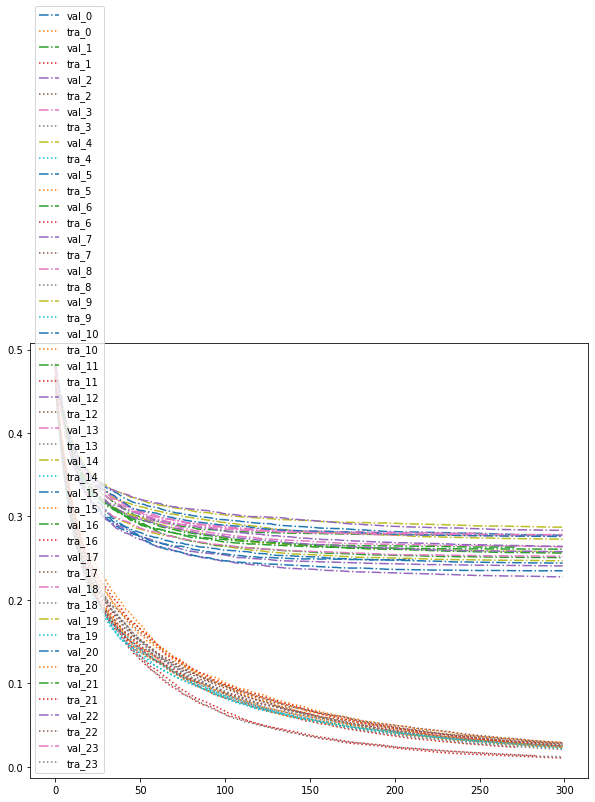

In [ ]:
zcls = '0x014c'
# zcls = '0x8664'
# zcls = 'NonPE'
paths = glob('./model/%s/*.dat'%zcls)
models = [load(path) for path in paths]
results = [model.evals_result() for model in models]
rmses = [res['validation_1']['rmse'][-1] for res in results]
epochs = [range(0,len(res['validation_0']['rmse'])) for res in results]
print(rmses)
plt.figure(figsize=(10,8))
for i in range(len(results)):
  plt.plot(epochs[i], results[i]['validation_1']['rmse'], '-.', label='val_%d'%i)
  plt.plot(epochs[i], results[i]['validation_0']['rmse'], ':', label='tra_%d'%i)
plt.legend(loc='lower left')
plt.show()

## **Y_hat구하기함수**

In [8]:
def predict(X_test, zcls, num = 0):
  # 해당 클래스 모델들 가져오기
  paths = glob('./model/%s/*.dat'%zcls)
  models = [load(path) for path in paths]

  # 상위 몇개 모델만
  if num:
    models = sorted(models, key=lambda x: x.evals_result()['validation_1']['rmse'][-1])
    models = models[:num]

  # 예측값 평균내기
  sum_pred = np.zeros(len(X_test))
  for model in tqdm(models):
    sum_pred += model.predict(X_test)
  avg_pred = sum_pred / len(models)

  # 0.5 이상은 1, 0.5 미만은 0
  avg_pred[avg_pred >= 0.5] = 1
  avg_pred[avg_pred < 0.5] = 0

  return avg_pred.astype(np.int)

## **정확도확인**

In [50]:
zcls = '0x014c'
# zcls = '0x8664'
# zcls = 'NonPE'
# zcls = '0x0166'
# zcls = '0x0184'
# zcls = '0x01c4'
# zcls = '0xaa64'
# zcls = 'elsePE'

path_que = glob('./features/%s/2019_*.npy'%zcls)
AX_valid, AY_valid, names = data_loader(path_que[0], 'all')

Y_pred = predict(AX_valid, '0x014c', 0) # 모델 종류별 예측
# Y_pred = predict(AX_valid, '0x8664')
# Y_pred = predict(AX_valid, 'NonPE')
print('\nacc : ', accuracy_score(Y_pred, AY_valid))

100%|██████████| 24/24 [03:25<00:00,  8.58s/it]


acc :  0.9714114114114114


## **Predict & Submission**

In [12]:
rows = []
zclass = ['0x014c', '0x0166', '0x0184', '0x01c4', \
          '0x8664', '0xaa64', 'NonPE', 'elsePE']

for zcls in zclass:
  # 테스트데이터 가져오기
  try:
    X_test, _, names = data_loader('./target_feature/%s.npy'%zcls, 'all')
  except:
    continue

  if zcls in ['0x014c']:
    Y_hat = predict(X_test, '0x014c')
  elif zcls in ['0x0166', '0x0184', '0x01c4', '0x8664', '0xaa64', 'elsePE']:
    Y_hat = predict(X_test, '0x8664')
  else:
    Y_hat = predict(X_test, 'NonPE')
  
  # 클래스별 예측값들 다 모으기
  rows += list(zip(names, Y_hat))

# 이름순 정렬
rows = sorted(rows, key=lambda x:x[0])
assert len(rows) == 10000

# 제출용 csv 만들기
with open('./submission_1.csv', 'w', newline='', encoding='utf-8') as f:
  cw = csv.writer(f)
  cw.writerow(['hash', 'result'])
  for row in rows:
    cw.writerow([row[0].split('.')[0], row[1]])

100%|██████████| 3/3 [00:00<00:00, 37.32it/s]


In [39]:
# 제출용 csv 만들기
with open('./test.csv', 'w', newline='', encoding='utf-8') as f:
  cw = csv.writer(f)
  cw.writerow(['hash', 'result'])
  for row in rows:
    cw.writerow([row[0].split('.')[0], row[1]])

## **제출보내기**

In [47]:
!cp -r ./submission_2.csv /content/drive/My\ Drive/share2/강로/

In [33]:
with open('./submission_2.csv', 'rb') as f:
  data = f.read()
  print(data[:100])
  data = data.replace(b'\r\n', b'\n')

with open('./submission_2.csv', 'wb') as f:
  f.write(data)

with open('./submission_2.csv', 'rb') as f:
  data = f.read()

print(data[:100])

b'hash,result\r\n0001ea7292f4c8befdcce6bc8a6fc5f81bf6b67c485c37be0297619527bad0a3,1\r\n00045b594bb5e252a97'
b'hash,result\n0001ea7292f4c8befdcce6bc8a6fc5f81bf6b67c485c37be0297619527bad0a3,1\n00045b594bb5e252a9771'


In [21]:
with open('./submission_1.csv', 'rb') as f:
  data = f.read()
data[:100]

b'hash,result\r\n0001ea7292f4c8befdcce6bc8a6fc5f81bf6b67c485c37be0297619527bad0a3.vir,1\r\n00045b594bb5e25'

In [46]:
with open('./submission_2.csv', 'rb') as f:
  data = f.read()
data[:100]

b'hash,result\n0001ea7292f4c8befdcce6bc8a6fc5f81bf6b67c485c37be0297619527bad0a3,1\n00045b594bb5e252a9771'